### Домашнее задание

Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab

In [1]:
!pip install split-folders

In [2]:
import os
import splitfolders
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import time
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

### Подготовка данных

In [36]:
# Создадим объекты для необходимых трансформаций нашего датасета:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                         tt.Resize((48, 48)),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

val_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize((48,48)), tt.ToTensor()])

### Подготовка датасета: разделение на train и val

In [4]:
data_dir = '/kaggle/input/leapgestrecog/leapGestRecog/'
output_dir = '/kaggle/working/data_gestes'
print(os.listdir(data_dir))
#print(os.listdir(data_dir + '/00'))

['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']


In [5]:
for folder in  os.listdir(data_dir):
    
    dir_temp = data_dir + folder
    splitfolders.ratio(dir_temp,seed=1337, output=output_dir, ratio=(0.8, 0.2))

Copying files: 2000 files [00:11, 173.02 files/s]
Copying files: 2000 files [00:09, 217.23 files/s]
Copying files: 2000 files [00:09, 203.46 files/s]
Copying files: 2000 files [00:12, 163.74 files/s]
Copying files: 2000 files [00:09, 207.88 files/s]
Copying files: 2000 files [00:10, 191.58 files/s]
Copying files: 2000 files [00:09, 210.25 files/s]
Copying files: 2000 files [00:10, 185.71 files/s]
Copying files: 2000 files [00:09, 204.28 files/s]
Copying files: 2000 files [00:09, 208.47 files/s]


### Просмор датасета

In [6]:
data_gestes = '/kaggle/working/data_gestes'
print(os.listdir(data_gestes))

['val', 'train']


In [7]:
classes_train = os.listdir(data_gestes + "/train")
classes_val = os.listdir(data_gestes + "/val")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_val}')
print(len(classes_train), len(classes_val))

Train Classes - ['05_thumb', '03_fist', '09_c', '01_palm', '04_fist_moved', '07_ok', '10_down', '06_index', '08_palm_moved', '02_l']
Validation Classes - ['05_thumb', '03_fist', '09_c', '01_palm', '04_fist_moved', '07_ok', '10_down', '06_index', '08_palm_moved', '02_l']
10 10


10 классов в каждой папке

In [37]:
train_ds = ImageFolder(data_gestes + '/train', train_tfms)
val_ds = ImageFolder(data_gestes + '/val', val_tfms)

In [38]:
train_ds

Dataset ImageFolder
    Number of datapoints: 16000
    Root location: /kaggle/working/data_gestes/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

Размер батча

In [11]:
batch_size = 200

In [39]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=1, pin_memory=True)

Функция для просмотра случайных картинок из получившегося датасета:

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


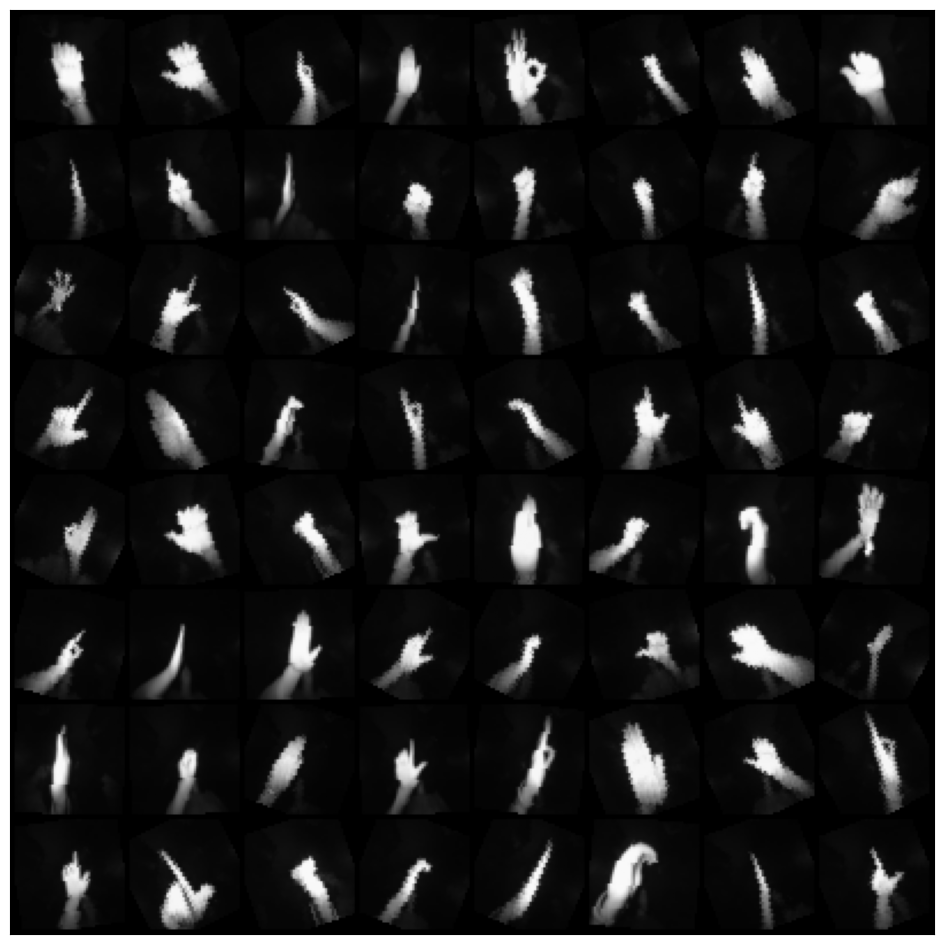

In [40]:
show_batch(train_dl)

Напишем функции для перевода наших Даталоадеров на необходимое оборудование:

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [55]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Создание модели

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [56]:
model = to_device(ResNet(1, len(classes_train)), device)

In [57]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

### Обучение

In [58]:
torch.cuda.empty_cache()
history = []

epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [59]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

10 epochs, 80 total_steps per epoch


In [60]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 80 == 0:    # печатаем каждые 80 mini-batches
            model.eval()

            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{batch_idx + 1}/{len(train_dl)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            
            val_running_right, val_running_total = 0.0, 0.0
            for batch_idx, (data, labels) in enumerate(val_dl):
                
                val_outputs = model(data.to(device))
                val_running_total += len(labels)
                val_running_right += (labels.to(device) == torch.max(val_outputs, 1)[1]).sum()

            print(f'Val acc: {val_running_right / val_running_total:.3f}')
                
            
    epoch_losses.append(epoch_loss)
    

Epoch [1/10]. Step [80/80]. Loss: 0.027. Acc: 0.222. Val acc: 0.391
Epoch [2/10]. Step [80/80]. Loss: 0.010. Acc: 0.282. Val acc: 0.569
Epoch [3/10]. Step [80/80]. Loss: 0.006. Acc: 0.586. Val acc: 0.550
Epoch [4/10]. Step [80/80]. Loss: 0.003. Acc: 0.749. Val acc: 0.838
Epoch [5/10]. Step [80/80]. Loss: 0.002. Acc: 0.839. Val acc: 0.887
Epoch [6/10]. Step [80/80]. Loss: 0.001. Acc: 0.902. Val acc: 0.982
Epoch [7/10]. Step [80/80]. Loss: 0.007. Acc: 0.662. Val acc: 0.395
Epoch [8/10]. Step [80/80]. Loss: 0.005. Acc: 0.601. Val acc: 0.721
Epoch [9/10]. Step [80/80]. Loss: 0.002. Acc: 0.835. Val acc: 0.824
Epoch [10/10]. Step [80/80]. Loss: 0.001. Acc: 0.915. Val acc: 0.975


Сохраним модель:

In [61]:
torch.save(model, '/kaggle/working/hand_gestes_recognition_model.pth')

Теперь загрузим ее и будем использовать:

In [63]:
net = torch.load('/kaggle/working/hand_gestes_recognition_model.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Прогоним нашу нейронную сеть через тестовый датасет (снимки сделанные через веб-камеру):

In [98]:
test = '/kaggle/input/test-dataset/test_1'

In [99]:
classes_test = os.listdir(test)
print(f'Train Classes - {classes_test}')

Train Classes - ['01_palm', '03_fist']


In [75]:
classes_test = os.listdir(test_gestes)
print(f'Train Classes - {classes_test}')

Train Classes - ['01_palm', '03_fist']


In [100]:
test_ds = ImageFolder(test, val_tfms)

batch_size = 1
test_dl = DataLoader(test_ds, batch_size, num_workers=1, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

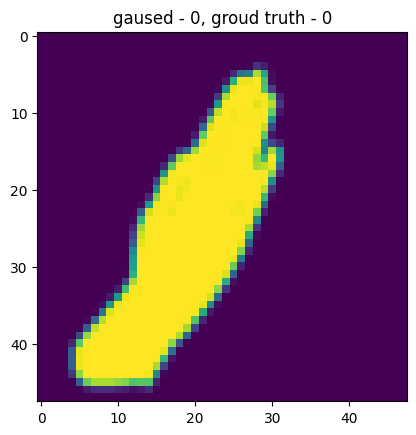

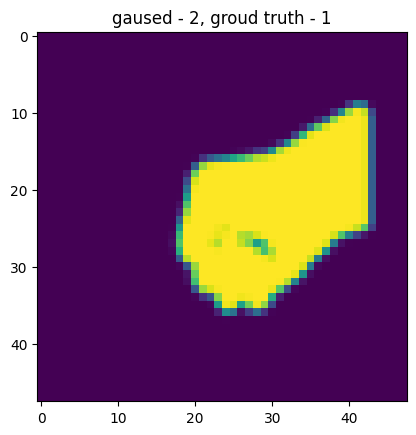

In [101]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        #images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)

        outputs = net(images)
        plt.title(f'gaused - {outputs[0].argmax()}, groud truth - {labels[0]}')
        plt.imshow(images[0].cpu().squeeze())
        plt.show()

Почему-то значения gaused показывают правильно, а ground truth показывают порядковый номер